In this notebook, we examine rasters of the NYC area over the past 2 years. Using a machine learning model trained to classify different kinds land cover, adapated for this landscape, we can better characterize the kind of land cover to exist here, and what changes have occurred.

In [8]:
import sys
sys.path.append('src')
from src.trainer import EuroSATTrainer
from src.load_data import get_eurosat_dataloaders
from src.load_data import download_eurosat_data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import torch
from collections import Counter
from datetime import datetime
import pandas as pd

# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load model which standardizes input impages
best_model_path = 'src/nyc-sentinel-src/3ivihb0d/checkpoints/epoch=49-step=15249.ckpt'
model = EuroSATTrainer.load_from_checkpoint(best_model_path)

if torch.cuda.is_available():
    model.to('cuda:0');
    print("Model sent to cuda.")



Model sent to cuda.


In [16]:
# create helper functions


def get_tiled_predictions(cropped_img,tile=64):
    img_height = raster.shape[1]
    img_width = raster.shape[2]

    tiled_array = np.zeros((cropped_img.shape[1],cropped_img.shape[2]))
    model.eval();
    tile_predictions = []
    tiled_images = []
    tiled_confidences = []
    tiled_indices = []
    with torch.no_grad():
        for i in range(0, img_height-tile, tile):
            for j in range(0, img_width-tile, tile):
                tiled_image = cropped_img[:,i:i+tile,j:j+tile]        
                if tiled_image.std() == 0:
                    tiled_array[i:i+tile,j:j+tile] = -1
                else:
                    x = torch.tensor(tiled_image.astype(np.int16))
                    x = (x - x.min()) / (x.max() - x.min())   
                    y_pred = model.forward(x.unsqueeze(0).cuda())
                    predicted_probs = y_pred.cpu().numpy()[0]
                    predicted_class = y_pred.argmax().cpu().item()
                    tiled_confidences.append(predicted_probs)
                    tiled_array[i:i+tile,j:j+tile] = predicted_class
                    tile_predictions.append(predicted_class)
                    tiled_images.append(tiled_image)
                    tiled_indices.append((i,j))

    return tile_predictions, tiled_array, tiled_images, tiled_confidences, tiled_indices




def crop_raster(raster,tile=64):
    img_height = raster.shape[1]
    img_width = raster.shape[2]

    num_vertical_tiles = img_height // tile
    num_horizontal_tiles = img_width // tile
    return raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]



def get_landmass_df(tile_predictions,date):
    tile_counter = Counter(tile_predictions)
    landmass_counts = {}
    for key in tile_counter.keys():
        landmass = label_dict[key].replace('/','')
        landmass_counts[landmass] = tile_counter[key]
        landmass_counts['date'] = date
    landmass_df = pd.DataFrame([landmass_counts])
    return landmass_df

In [10]:
# grab label dictionary
_, _, _, label_dict = get_eurosat_dataloaders(batch_size = 1, limit=1, test_size = .1)
print(label_dict)

100%|██████████| 1/1 [00:00<00:00, 4728.64it/s]

{0: '/AnnualCrop', 1: '/Forest', 2: '/HerbaceousVegetation', 3: '/Highway', 4: '/Industrial', 5: '/Pasture', 6: '/PermanentCrop', 7: '/Residential', 8: '/River', 9: '/SeaLake'}


In [11]:
label_dict = {0:'Seasonal Vegetation',
             1:'Forests',
             2:'Seasonal Vegetation',
             3:'Human Activity',
             4:'Human Activity',
             5:'Grass',
             6:'Permanent Vegetation',
             7:'Human Activity',
             8:'Water',
             9:'Water'}

As seen from above, I refined the definition of the categories. The motivation for doing so is that the EuroSAT dataset is based on relatively even landmass types found in Europe, and are no longer as relevant to the kinds of analysis I hope to do here. 

In [20]:
rasters = [f for f in os.listdir('data/') if f.endswith('.tiff')]
landmass_change_df = pd.DataFrame()
for img in tqdm(rasters):
    # open image
    date = img.split('_')[2].split('T')[0]
    raster = rio.open(f'data/{img}').read()
    cropped_img = crop_raster(raster)
    tile_predictions, tiled_array, tiled_images, tiled_confidences, tiled_indices = get_tiled_predictions(cropped_img)    
    year = date[:4]
    month = date[4:6]
    day = date[6:]
    date_str = f"{year}-{month}-{day}"
    date = datetime.strptime(date_str, '%Y-%m-%d')
    landmass_df = get_landmass_df(tile_predictions,date)
    landmass_change_df = landmass_change_df.append(landmass_df)

100%|██████████| 21/21 [08:52<00:00, 25.36s/it]


In [23]:
landmass_change_df.fillna(0,inplace=True)

In [85]:
landmass_change_df_2022 = landmass_change_df[landmass_change_df['date'] > '2022-01-01']

In [86]:
landmass_change_df_2022_ = landmass_change_df_2022.copy()

In [87]:
for col in landmass_change_df_2022.drop(columns=['date']).columns:
    landmass_change_df_2022[col] = landmass_change_df_2022[col] / landmass_change_df_2022_.drop(columns=['date']).sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, '% of Landscape')

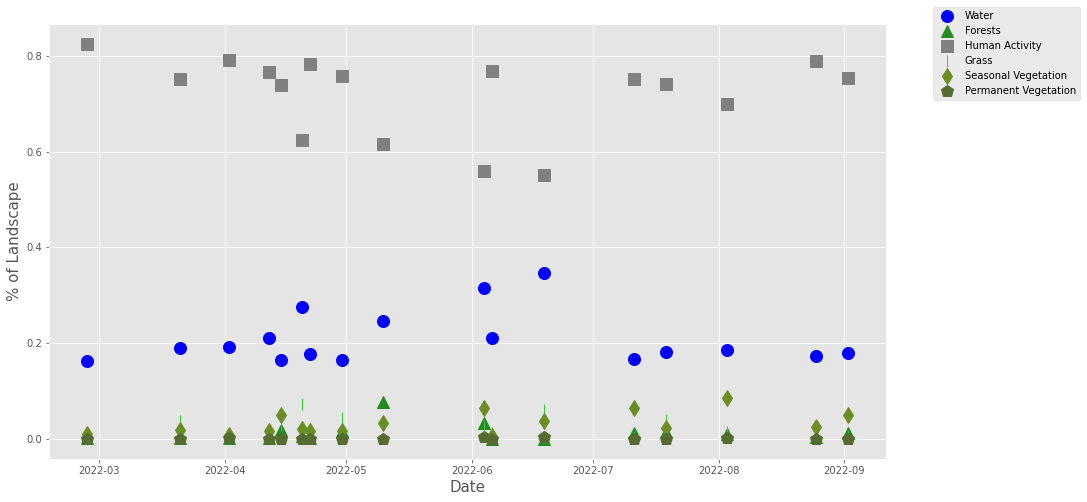

In [90]:
plt.figure(figsize=(15,8))
ax = plt.subplot(111)
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Water'],linewidth=0,marker='o',color='blue',markersize=12,label='Water')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Forests'],linewidth=0,marker='^',color='forestgreen',markersize=12,label='Forests')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Human Activity'],linewidth=0,marker='s',color='grey',markersize=12,label='Human Activity')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Grass'],linewidth=0,marker='|',color='limegreen',markersize=12,label='Grass')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Seasonal Vegetation'],linewidth=0,marker='d',color='olivedrab',markersize=12,label='Seasonal Vegetation')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Permanent Vegetation'],linewidth=0,marker='p',color='darkolivegreen',markersize=12,label='Permanent Vegetation')
ax.legend(bbox_to_anchor=(1.05, 1.05))

plt.xlabel("Date",fontsize=15)
plt.ylabel("% of Landscape",fontsize=15)

In [114]:
most_water_raster = rio.open('data/S2A_MSIL2A_20220619T154821_N0400_R054_T18TWL_20220619T232314.tiff').read()
most_human_activity_raster = rio.open('data/S2A_MSIL2A_20220226T154221_N0400_R011_T18TWL_20220226T204651.tiff').read()
test_raster =rio.open('data/S2B_MSIL2A_20220902T154809_N0400_R054_T18TWL_20220902T200807.tiff').read()

In [ ]:
plt.figure(figsize=(30,15))
plt.subplot(121)
plt.title("Feb 2022",fontsize=25)
plt.imshow(most_human_activity_raster.mean(axis=0),cmap='gray')
plt.subplot(122)
plt.title("Jun 2022",fontsize=25)
plt.imshow(most_water_raster.mean(axis=0),cmap='gray')

From this side by side, what I've can observe which would lead to this change in predicted water level:

In general, water is brighter colored. 
Cloud cover in north of Queens is blocking some water, which may have affected the # of predicted water tiles there.
Same applies for the cloud cover over jersey city in June. 

There is a lake that appears to top up in the second from the top left . This appears to be Overpeck Preserve, which from what I can tell, does indeed change! According to the site's website, this area is composed of "vernal pools", which are seasonal ponds. 

https://njaudubon.org/wp-content/wildlife/MeadowlandsTrails/Sites/tabid/443/Scope/site/Guide/MEADOWLNDS/Site/109/Default.html

So that might explain why this increase in detected water took place!



That gives some insight into the two most prominent land covers, manmade versus water. 

While it's awesome that I could detect the onset of water through seasonal pools, the lingering issues with cloud cover are definitely something to keep an eye on in a next steps version of this. 

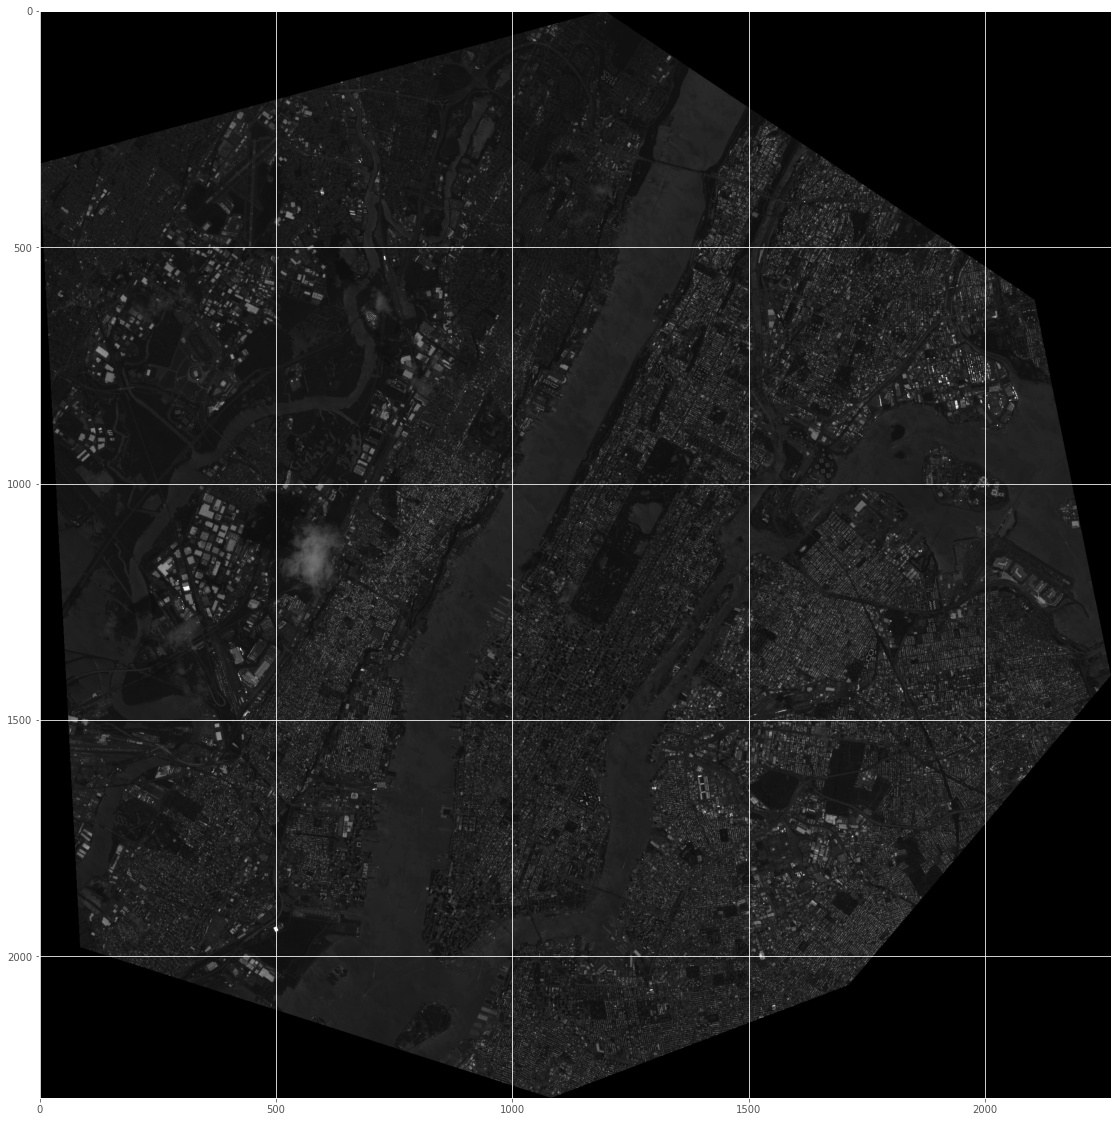

In [120]:

plt.figure(figsize=(20,20))
plt.imshow(most_water_raster.mean(axis=0),cmap='gray')
